In [2]:
import arrow
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

In [3]:
def map():
  # create space for drawing
  proj = ccrs.PlateCarree()  #create coordinate
  fig = plt.figure(figsize=(10, 5))  #create figure
  ax = fig.subplots(1, 1, subplot_kw={'projection': proj})  #create sub-plot
  # set map parameters
  ax.add_feature(cfeat.BORDERS.with_scale('50m'), linewidth=0.8)  #add borders
  ax.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=0.6)  #add coastlines
  ax.add_feature(cfeat.RIVERS.with_scale('50m'))  #add rivers
  ax.add_feature(cfeat.LAKES.with_scale('50m'))  #add lakes
  # set up gridlines
  gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1.2, color='k', alpha=0.5, linestyle='--')
  gl.xlabels_top = False  #remove x labels
  gl.ylabels_right = False  #remove y lables
  gl.xformatter = LONGITUDE_FORMATTER  #set x as lon
  gl.yformatter = LATITUDE_FORMATTER  #set y as lat
  return fig, ax

In [4]:
import warnings
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd


warnings.filterwarnings('ignore')


xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

#https://nbviewer.jupyter.org/github/pangeo-data/pangeo-cmip6-examples/blob/master/search_and_load_with_esgf_opendap.ipynb


## Search using ESGF API

In [5]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

## Load data with xrray

In [15]:
def CMIP_processing_plot(my_result, my_experiment_id, my_varname, my_model, my_source, index_initial, index_end):
   # there are mulitple sources of the same data--need to pick one
    index_ini=index_initial#3
    index_fin=index_end#11

    files_to_open = my_result[index_ini:index_fin+1]

    n_files= len(files_to_open)
    print ('number of files to open:', n_files)
    
#     for ires in range(n_files):
#         print(ires,':', files_to_open[ires])
        

    
    myvarvals=[]
    myvarvals_values = []
    time_appropriate = []
    
    #define a boundary
    ds=xr.open_dataset(files_to_open[0])
    lat = ds.lat
    lon = ds.lon
    lat_range = lat[(lat>=-20)&(lat<=10)]
    lon_range = lon[(lon>=270)&(lon<=330)]
    for ifls in range(n_files):
        ds=xr.open_dataset(files_to_open[ifls])
        # fix CF non standard time issues
        if ds.time.dtype == 'O' and int(ds.indexes['time'][-1].strftime("%Y")) < 2262:
                datetimeindex = ds.indexes['time'].to_datetimeindex()
                ds['time'] = datetimeindex
        # filter some files have different time range
        if ds['time.year'][0].values >= 2060 and ds['time.year'][0].values <= 2099:
            ds_am= ds.sel(lon = lon_range, lat = lat_range)
            myvarvals.append(ds_am)
#             myvarvals_values.append(ds_am.values) 
#             time_appropriate.append(ifls)
#     print(myvarvals)
   # Yanlei
   # concatenate all the data together by dimension "time.year"
    ds_concat = xr.concat(myvarvals, dim="time")
    # select the time between 2070-01 to 2099-12
    ds_3hr = ds_concat.sel(time=slice('2070','2071')) #ds_3hr is dataset with correct variable name

#     ds_3hr = ds_concat.sel(time=slice('2070-01','2099-12')) #ds_3hr is dataset with correct variable name
#     # Since this is 3hr interval, select only every 6hr 
#     ds_6hr_all = ds_3hr.sel(time=ds_3hr.time.dt.hour.isin([0,6,12,18])) #ds_6hr is dataset with correct variable name
#     ds_6hr = ds_6hr_all[["tas"]]
    ds_6hr = ds_3hr[["tas"]]
    print(ds_6hr.sizes)
    print(ds_6hr["time.year"])
    print(ds_6hr["time.month"])
    print(ds_6hr["time.hour"])


#     avgda_ds = avgda.to_dataset(name = 'tas')
#     print(avgda_ds)
    #===================================================
    #plotting
    #====================================================


    DIRin='/Users/yanlei/Documents/PhD/4B/Deep convections in Amazon/future_hourly_CAPE_rho_p/data/tas/' 

    filename=DIRin+my_experiment_id+'_'+my_varname+'_6hr_2070_2099_'+my_model+'_'+my_source+'.nc'
    
    # save xarrays to netcdf files
    ds_6hr.to_netcdf(filename)
    


    # create map
    ds_map = ds_6hr.isel(time = 0).tas
    fig, ax = map()
    
    title= my_experiment_id+'_'+my_varname+'_6hr_1970_01_01_'+my_model+'_'+my_source
    ds_map.plot.contourf(ax=ax, cmap='Spectral_r', extend='both',
        transform=ccrs.PlateCarree())
    plt.title(title)
    fig.show()

 

In [71]:
# result_0 = esgf_search(activity_id='ScenarioMIP', table_id='3hr', variable_id='tas', experiment_id='ssp585', 
#                     latest=True)
# #result
# for ires in range(len(result_0)):
#     print(ires,':', result_0[ires])

# 1. BCC, BCC-CSM2-MR

In [72]:
result_BCC = esgf_search(activity_id='ScenarioMIP', table_id='3hr',  variable_id='tas', experiment_id='ssp585', 
                    institution_id="BCC", source_id= "BCC-CSM2-MR",latest=True)
#result
for ires in range(len(result_BCC)):
    print(ires,':', result_BCC[ires])

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=3hr&variable_id=tas&experiment_id=ssp585&institution_id=BCC&source_id=BCC-CSM2-MR&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=3hr&variable_id=tas&experiment_id=ssp585&institution_id=BCC&source_id=BCC-CSM2-MR&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=3hr&variable_id=tas&experiment_id=ssp585&institution_id=BCC&source_id=BCC-CSM2-MR&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=3hr&variable_id=tas&experiment_id=ssp585&institution_id=BCC&source_id=BCC-CSM2-MR&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2B

number of files to open: 16
Frozen(SortedKeysDict({'lat': 27, 'lon': 54, 'time': 43800}))
<xarray.Dataset>
Dimensions:  (lat: 27, lon: 54, time: 43800)
Coordinates:
  * time     (time) datetime64[ns] 2070-01-01 ... 2099-12-31T18:00:00
  * lat      (lat) float64 -19.63 -18.5 -17.38 -16.26 ... 6.168 7.29 8.411 9.533
  * lon      (lon) float64 270.0 271.1 272.2 273.4 ... 326.2 327.4 328.5 329.6
    height   float64 2.0
Data variables:
    tas      (time, lat, lon) float32 298.6 298.4 298.3 ... 301.8 301.8 301.8
Attributes: (12/50)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     ScenarioMIP
    branch_method:                   Standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           2015.0
    comment:                         This is an extension of historical simul...
    ...                              ...
    tracking_id:                     hdl:21.14100/effaba31-afa9-4dcb-9277-fde...
    variable_id:              

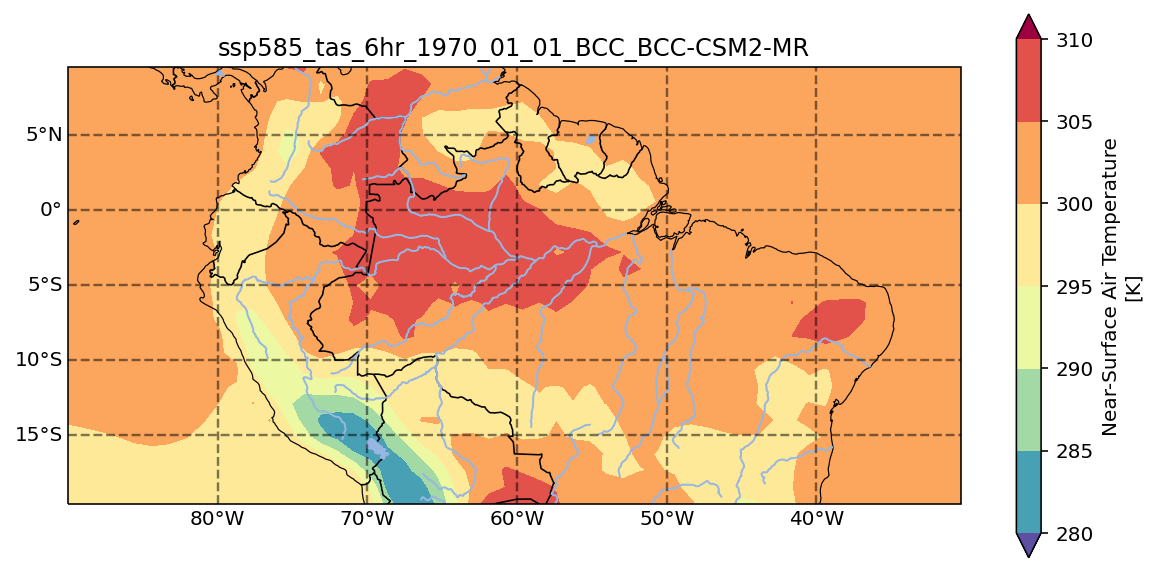

In [86]:
fig = CMIP_processing_plot(result_BCC, 'ssp585', 'tas', "BCC", "BCC-CSM2-MR", 42, len(result_BCC))

# 2. CCCma, CanESM5

In [7]:
result_CCCma = esgf_search(activity_id='ScenarioMIP', table_id='3hr',  variable_id='tas', experiment_id='ssp585', 
                    institution_id="CCCma", source_id= "CanESM5",latest=True)
for ires in range(len(result_CCCma)):
    print(ires,':', result_CCCma[ires])

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=3hr&variable_id=tas&experiment_id=ssp585&institution_id=CCCma&source_id=CanESM5&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=3hr&variable_id=tas&experiment_id=ssp585&institution_id=CCCma&source_id=CanESM5&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
0 : http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgA_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p2f1/3hr/tas/gn/v20190429/tas_3hr_CanESM5_ssp585_r1i1p2f1_gn_201501010300-202101010000.nc
1 : http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgA_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p2f1/3hr/tas/gn/v20190429/tas_3hr_CanESM5_ssp585_r1i1p2f1_gn_202101010300-203101010000.nc
2 : http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgA_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp5

number of files to open: 5
Frozen(SortedKeysDict({'time': 5840, 'lat': 11, 'lon': 22}))
<xarray.DataArray 'year' (time: 5840)>
array([2070, 2070, 2070, ..., 2071, 2071, 2071])
Coordinates:
  * time     (time) datetime64[ns] 2070-01-01 ... 2071-12-31T21:00:00
    height   float64 2.0
<xarray.DataArray 'month' (time: 5840)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
  * time     (time) datetime64[ns] 2070-01-01 ... 2071-12-31T21:00:00
    height   float64 2.0
<xarray.DataArray 'hour' (time: 5840)>
array([ 0,  3,  6, ..., 15, 18, 21])
Coordinates:
  * time     (time) datetime64[ns] 2070-01-01 ... 2071-12-31T21:00:00
    height   float64 2.0


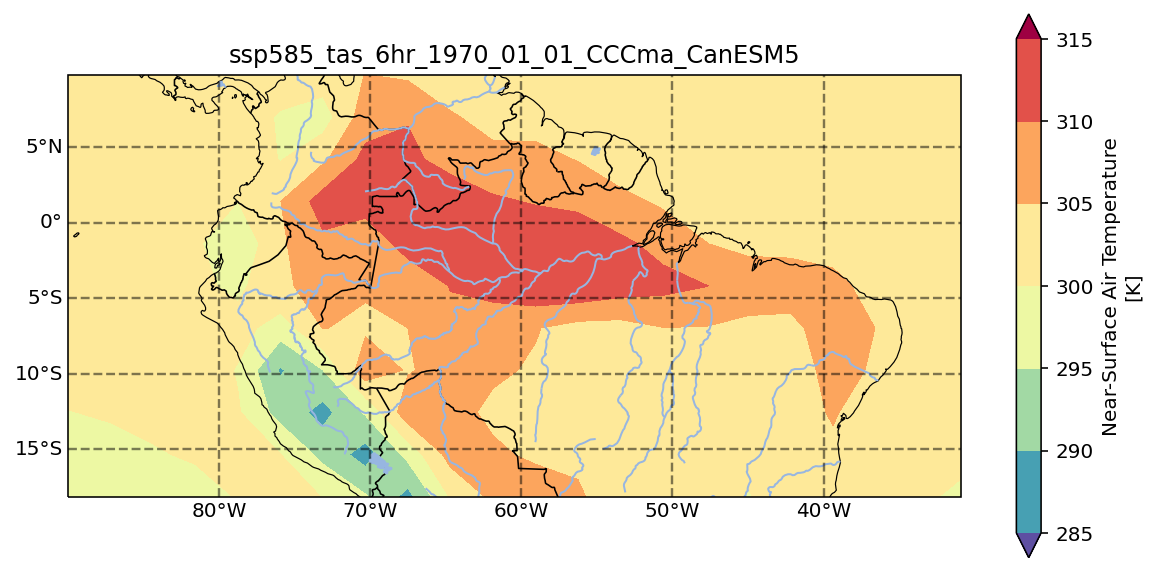

In [16]:
fig = CMIP_processing_plot(result_CCCma, 'ssp585', 'tas', 'CCCma', 'CanESM5',5, 9)

# 3. NCAR, CESM2

In [10]:
result_NCAR_CESM2 = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="NCAR", source_id= "CESM2",latest=True)
#result
for ires in range(len(result_NCAR_CESM2)):
    print(ires,':', result_NCAR_CESM2[ires])

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=NCAR&source_id=CESM2&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=NCAR&source_id=CESM2&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
0 : http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r10i1p1f1/Amon/tas/gn/v20200528/tas_Amon_CESM2_ssp585_r10i1p1f1_gn_201501-206412.nc
1 : http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r10i1p1f1/Amon/tas/gn/v20200528/tas_Amon_CESM2_ssp585_r10i1p1f1_gn_206501-210012.nc
2 : http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r11i1p1f1/Amon/tas/gn/v20200528/tas_Amon_CESM2_ssp585_

number of files to open: 16
<xarray.Dataset>
Dimensions:  (lat: 32, lon: 47)
Coordinates:
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 8.01 8.953 9.895
  * lon      (lon) float64 271.2 272.5 273.8 275.0 ... 325.0 326.2 327.5 328.8
Data variables:
    tas      (lat, lon) float32 295.1 295.1 295.1 295.2 ... 302.9 302.9 303.0


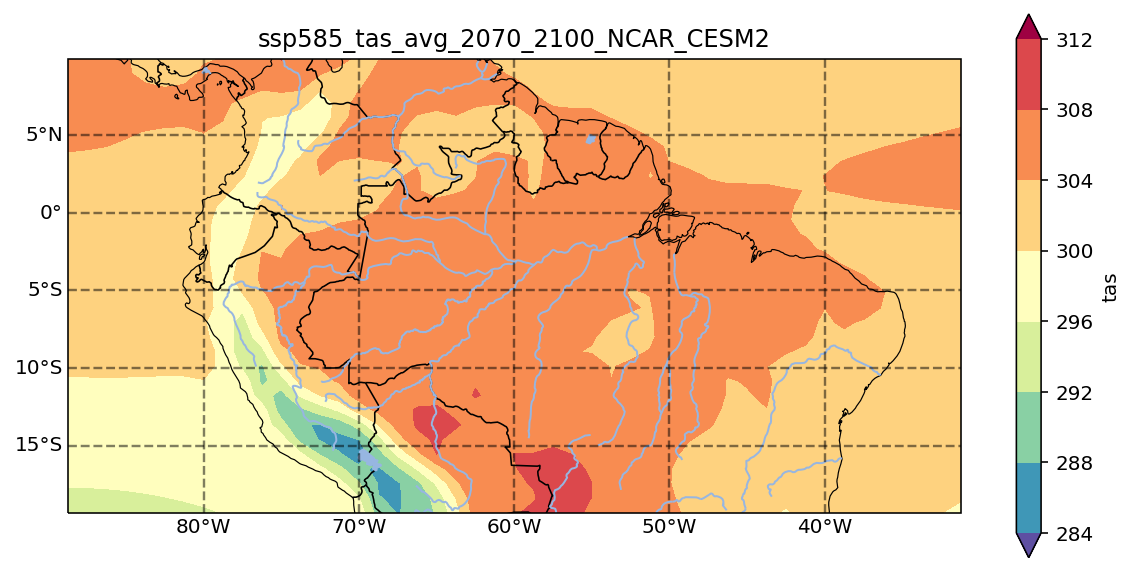

In [11]:
fig = CMIP_processing_plot(result_NCAR_CESM2, 'ssp585', 'tas', "NCAR", "CESM2", 0, 15)

# 4. NOAA-GFDL, GFDL-CM4

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=NOAA-GFDL&source_id=GFDL-CM4&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
0 : http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_ssp585_r1i1p1f1_gr1_201501-210012.nc
1 : http://esgf-data3.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-CM4_ssp585_r1i1p1f1_gr1_201501-210012.nc
number of files to open: 3
<xarray.Dataset>
Dimensions:  (lat: 32, lon: 47)
Coordinates:
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 8.01 8.953 9.895
  * lon      (lon) float64 271.2 272.5 273.8 275.0 ... 325.0 326.2 327.5 328.8
Data variables:
    tas      (lat, lon) float32 295.1 295.1 295.1 295.1 ... 303.0 303.0 303.0


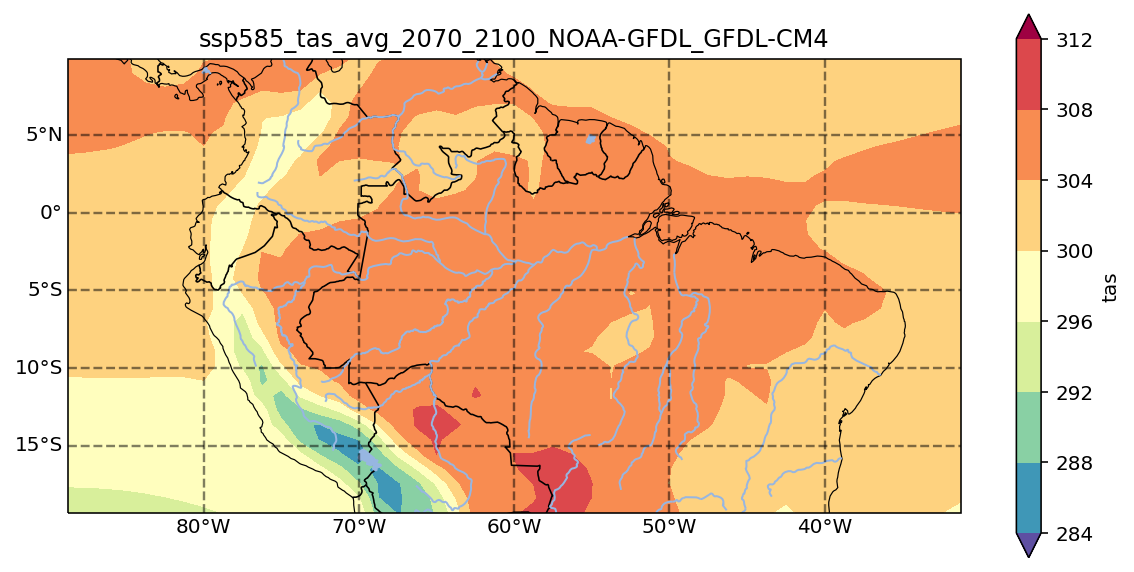

In [12]:
result_NOAA_GFDL_GFDL_CM4 = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="NOAA-GFDL", source_id= "GFDL-CM4",latest=True)
#result
for ires in range(len(result_NOAA_GFDL_GFDL_CM4)):
    print(ires,':', result_NOAA_GFDL_GFDL_CM4[ires])
    
fig = CMIP_processing_plot(result_NCAR_CESM2, 'ssp585', 'tas', "NOAA-GFDL", "GFDL-CM4", 0, len(result_NOAA_GFDL_GFDL_CM4))

# 5. MIROC, MIROC6

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MIROC&source_id=MIROC6&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MIROC&source_id=MIROC6&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MIROC&source_id=MIROC6&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MIROC&source_id=MIROC6&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&off

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 42)
Coordinates:
  * lat      (lat) float64 -18.91 -17.51 -16.11 -14.71 ... 6.303 7.704 9.105
  * lon      (lon) float64 271.4 272.8 274.2 275.6 ... 324.8 326.2 327.7 329.1
    height   float64 ...
Data variables:
    tas      (lat, lon) float32 295.5 295.4 295.4 295.5 ... 301.9 302.0 302.0


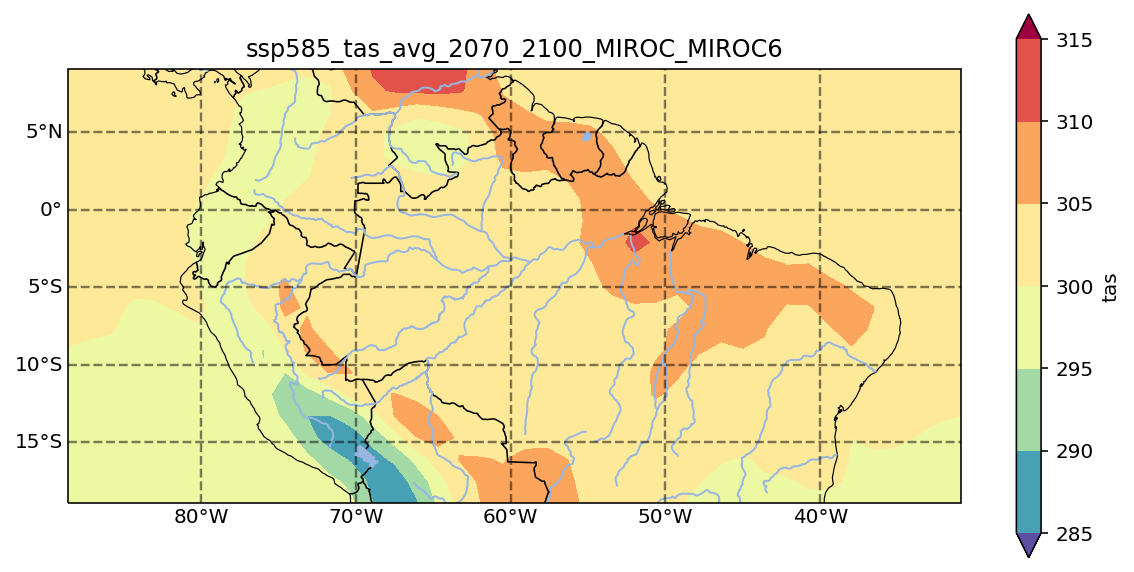

In [13]:
result_MIROC_MIROC6 = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="MIROC", source_id= "MIROC6",latest=True)
#result
for ires in range(len(result_MIROC_MIROC6)):
    print(ires,':', result_MIROC_MIROC6[ires])
    
fig = CMIP_processing_plot(result_MIROC_MIROC6, 'ssp585', 'tas', "MIROC", "MIROC6", 0, len(result_MIROC_MIROC6))

# 6. MIROC, MIROC-ES2L

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MIROC&source_id=MIROC-ES2L&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MIROC&source_id=MIROC-ES2L&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
0 : http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp585/r1i1p1f2/Amon/tas/gn/v20190823/tas_Amon_MIROC-ES2L_ssp585_r1i1p1f2_gn_201501-210012.nc
1 : http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp585/r10i1p1f2/Amon/tas/gn/v20201222/tas_Amon_MIROC-ES2L_ssp585_r10i1p1f2_gn_201501-210012.nc
2 : http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/MIROC/MIROC-ES2L/ssp585/r1i1p1f2/Am

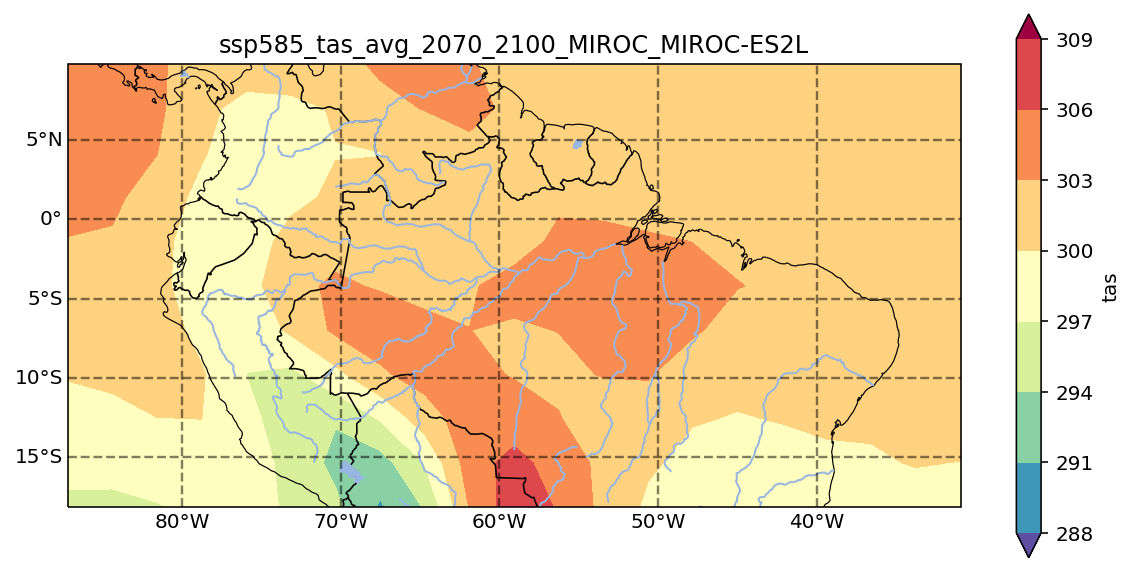

In [14]:
result_MIROC_MIROC_ES2L = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="MIROC", source_id= "MIROC-ES2L",latest=True)
#result
for ires in range(len(result_MIROC_MIROC_ES2L)):
    print(ires,':', result_MIROC_MIROC_ES2L[ires])
    
fig = CMIP_processing_plot(result_MIROC_MIROC_ES2L, 'ssp585', 'tas', "MIROC", "MIROC-ES2L", 0, len(result_MIROC_MIROC_ES2L))

# 7. MRI, MRI-ESM2-0

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MRI&source_id=MRI-ESM2-0&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
0 : http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp585/r1i2p1f1/Amon/tas/gn/v20191205/tas_Amon_MRI-ESM2-0_ssp585_r1i2p1f1_gn_201501-210012.nc
1 : http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp585/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_201501-210012.nc
2 : http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp585/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_210101-230012.nc
3 : http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/MRI/MRI-ESM2-0/ssp585/r1i2p1f1/Amon/tas/gn/v20191205/tas_Amon_MRI-ESM2-0_ssp585_r1i2p1f1_gn_201501-210012.nc
num

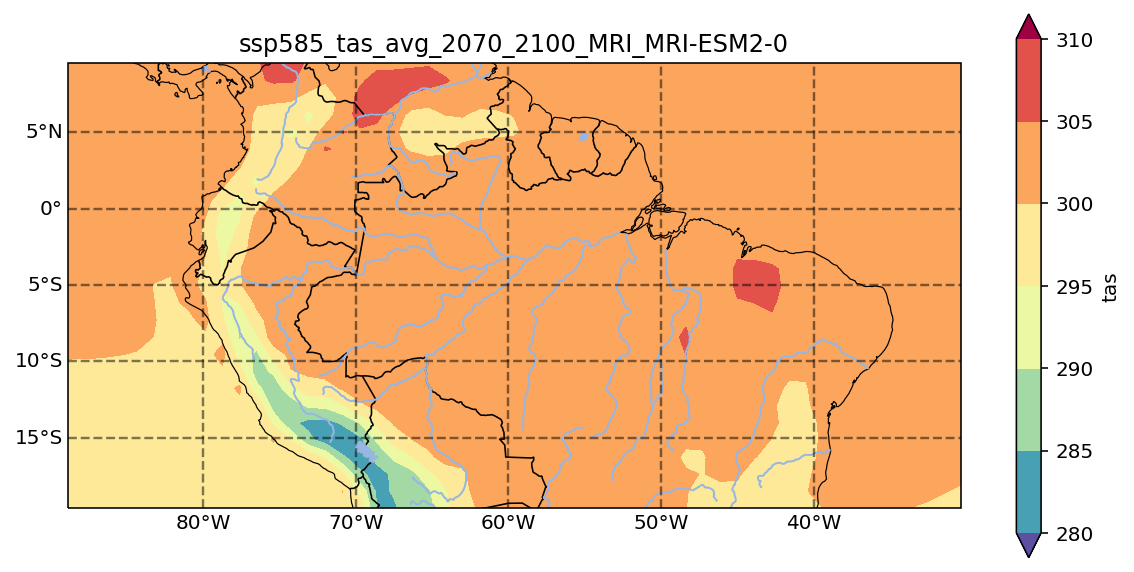

In [15]:
result_MIR_MRI_ESM2_0 = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="MRI", source_id= "MRI-ESM2-0",latest=True)
#result
for ires in range(len(result_MIR_MRI_ESM2_0)):
    print(ires,':', result_MIR_MRI_ESM2_0[ires])
    
fig = CMIP_processing_plot(result_MIR_MRI_ESM2_0, 'ssp585', 'tas', "MRI", "MRI-ESM2-0", 0, len(result_MIR_MRI_ESM2_0))

# 8. BCC, BCC-CSM2-MR

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=BCC&source_id=BCC-CSM2-MR&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
0 : http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Amon/tas/gn/v20190314/tas_Amon_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_201501-210012.nc
1 : http://cmip.bcc.cma.cn/thredds/dodsC/cmip6_data/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Amon/tas/gn/v20190314/tas_Amon_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_201501-210012.nc
2 : http://esgf-data3.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Amon/tas/gn/v20190314/tas_Amon_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_201501-210012.nc
number of files to open: 1
<xarray.Dataset>
Dimensions:  (lat: 27, lon: 53)
Coordinates:
  * lat      (lat) float64 -19.63 -18.5 -17.38 -16.26 ... 6.168 7.29 8.411 9.533
  * lon      (lon) float64 271.1

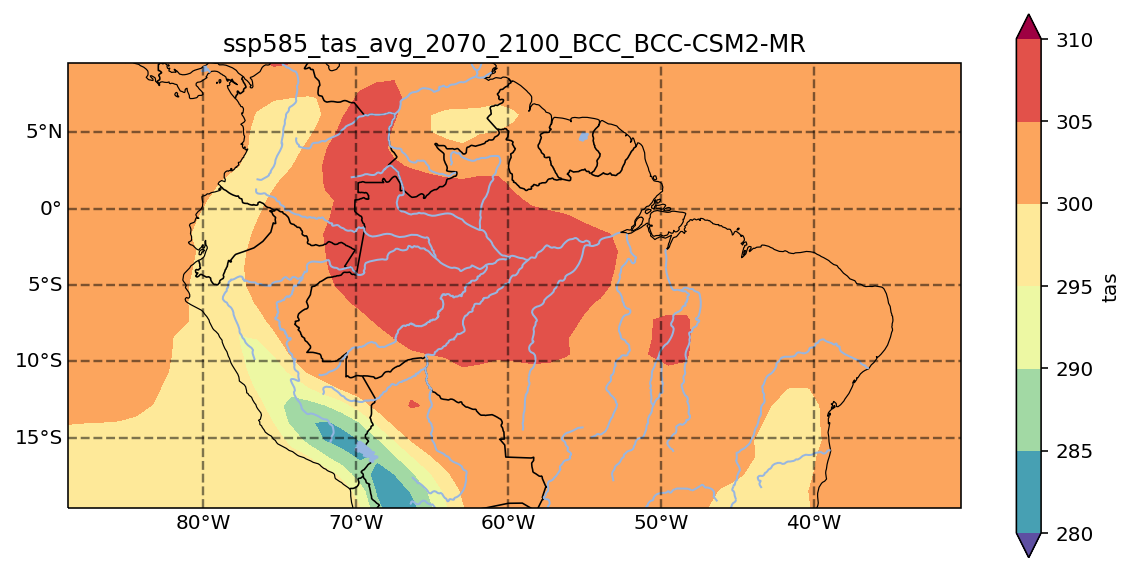

In [17]:
result_BCC_BCC_CSM2_MR = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="BCC",source_id= "BCC-CSM2-MR", latest=True)
#result
for ires in range(len(result_BCC_BCC_CSM2_MR)):
    print(ires,':', result_BCC_BCC_CSM2_MR[ires])
    
fig = CMIP_processing_plot(result_BCC_BCC_CSM2_MR, 'ssp585', 'tas', "BCC", "BCC-CSM2-MR", 0, 0)

# 9. MOHC, HadGEM3-GC31-LL

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MOHC&source_id=HadGEM3-GC31-LL&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=MOHC&source_id=HadGEM3-GC31-LL&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
0 : http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31-LL/ssp585/r1i1p1f3/Amon/tas/gn/v20200114/tas_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_201501-204912.nc
1 : http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31-LL/ssp585/r1i1p1f3/Amon/tas/gn/v20200114/tas_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc
2 : http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31-L

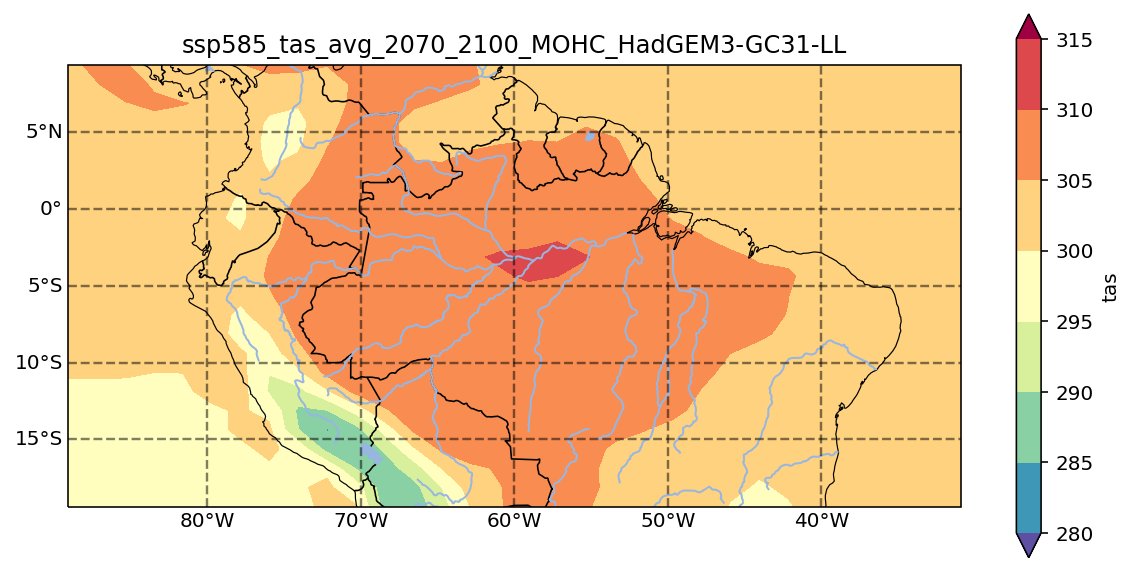

In [18]:
result_MOHC = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="MOHC",source_id= "HadGEM3-GC31-LL", latest=True)
#result
for ires in range(len(result_MOHC)):
    print(ires,':', result_MOHC[ires])
    
fig = CMIP_processing_plot(result_MOHC, 'ssp585', 'tas', "MOHC", "HadGEM3-GC31-LL", 0, len(result_MOHC))

# 10. CCCma, CanESM5

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=CCCma&source_id=CanESM5&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=CCCma&source_id=CanESM5&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=CCCma&source_id=CanESM5&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=CCCma&source_id=CanESM5&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson

<xarray.Dataset>
Dimensions:  (lat: 11, lon: 21)
Coordinates:
  * lat      (lat) float64 -18.14 -15.35 -12.56 -9.767 ... 4.186 6.977 9.767
  * lon      (lon) float64 272.8 275.6 278.4 281.2 ... 320.6 323.4 326.2 329.1
    height   float64 ...
Data variables:
    tas      (lat, lon) float32 297.6 298.0 298.4 299.0 ... 304.0 304.2 304.4


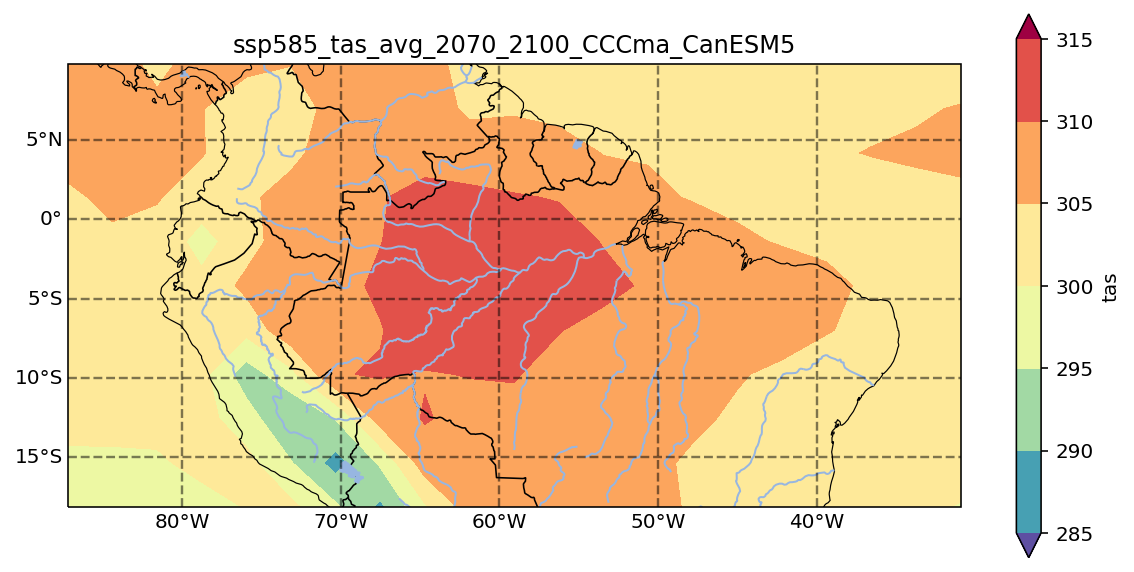

In [19]:
result_CCCma = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="CCCma", source_id= "CanESM5", latest=True)
#result
for ires in range(len(result_CCCma)):
    print(ires,':', result_CCCma[ires])
    
fig = CMIP_processing_plot(result_CCCma, 'ssp585', 'tas', "CCCma", "CanESM5", 0, 20)

# 11. IPSL, IPSL-CM6A-LR

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=IPSL&source_id=IPSL-CM6A-LR&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=IPSL&source_id=IPSL-CM6A-LR&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
0 : http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r14i1p1f1/Amon/tas/gr/v20191121/tas_Amon_IPSL-CM6A-LR_ssp585_r14i1p1f1_gr_201501-210012.nc
1 : http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1i1p1f1/Amon/tas/gr/v20190903/tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc
2 : http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1i1p1f1/A

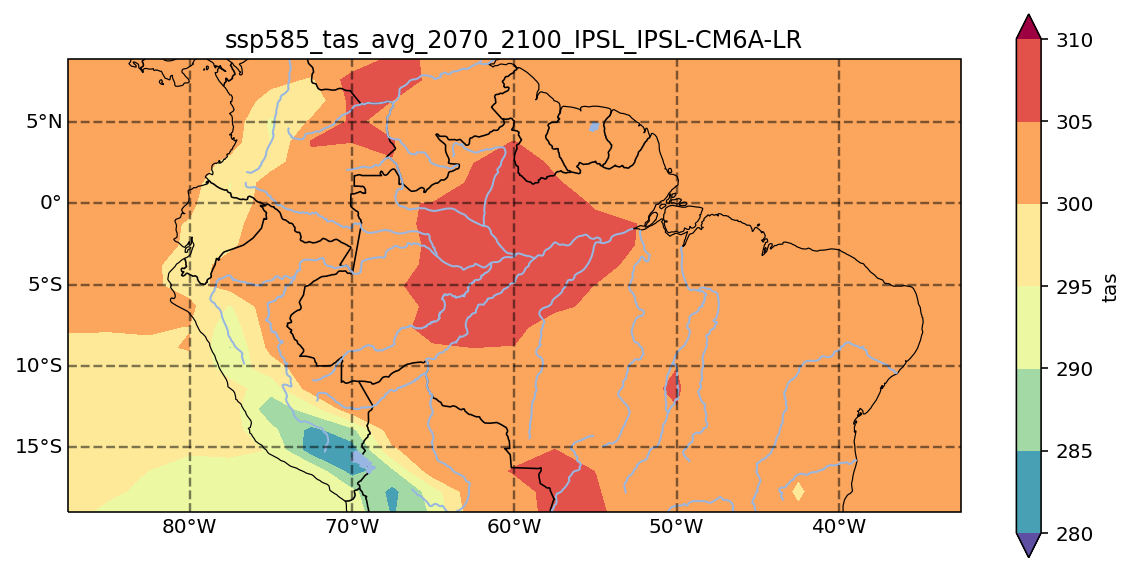

In [20]:
result_IPSL = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="IPSL",source_id= "IPSL-CM6A-LR", latest=True)
#result
for ires in range(len(result_IPSL)):
    print(ires,':', result_IPSL[ires])
    
fig = CMIP_processing_plot(result_IPSL, 'ssp585', 'tas', "IPSL","IPSL-CM6A-LR", 0, len(result_IPSL))

# 12. CNRM-CERFACS, CNRM-CM6-1 

https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=ScenarioMIP&table_id=Amon&variable_id=tas&experiment_id=ssp585&institution_id=CNRM-CERFACS&source_id=CNRM-CM6-1&latest=True&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
0 : http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp585/r1i1p1f2/Amon/tas/gr/v20190219/tas_Amon_CNRM-CM6-1_ssp585_r1i1p1f2_gr_201501-210012.nc
1 : http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp585/r2i1p1f2/Amon/tas/gr/v20190410/tas_Amon_CNRM-CM6-1_ssp585_r2i1p1f2_gr_201501-210012.nc
2 : http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp585/r

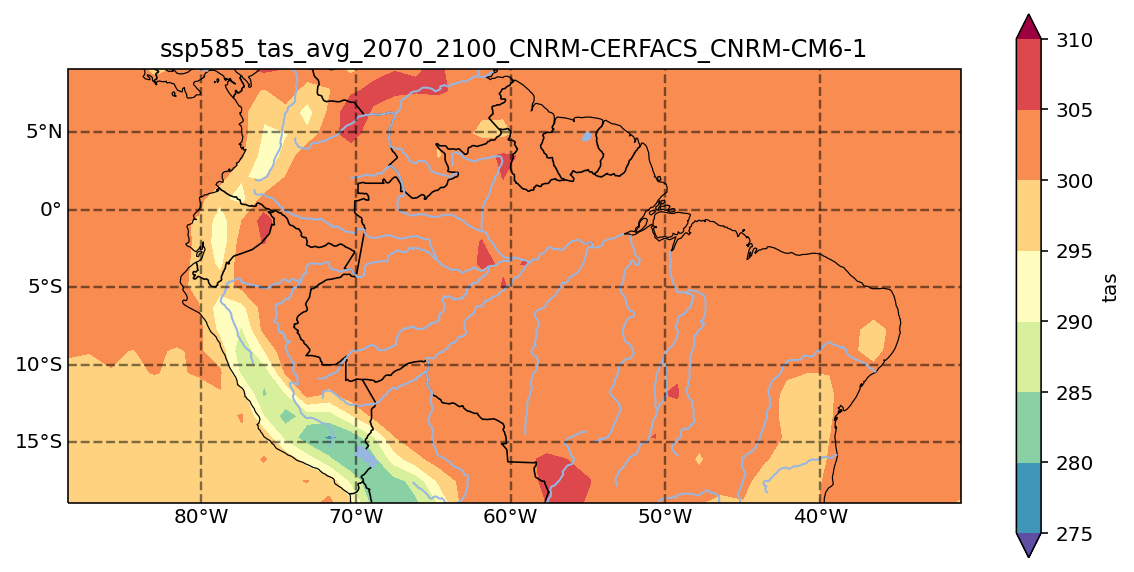

In [21]:
result_CNRM = esgf_search(activity_id='ScenarioMIP', table_id='Amon', variable_id='tas', experiment_id='ssp585', 
                    institution_id="CNRM-CERFACS",source_id= "CNRM-CM6-1", latest=True)
#result
for ires in range(len(result_CNRM)):
    print(ires,':', result_CNRM[ires])
    
fig = CMIP_processing_plot(result_CNRM, 'ssp585', 'tas', "CNRM-CERFACS","CNRM-CM6-1", 0, len(result_CNRM))